In [84]:
import numpy as np 
import scipy, h5py
import tables
import sys
from scipy.optimize import minimize
from numpy.polynomial import legendre as LG
import matplotlib.pyplot as plt

filename = 'pure/calib+0.01.h5'

# read files by table
h1 = tables.open_file(filename,'r')
print(filename)
truthtable = h1.root.GroundTruth
EventID = truthtable[:]['EventID']
ChannelID = truthtable[:]['ChannelID']
PETime = truthtable[:]['PETime']
h1.close()

pure/calib+0.01.h5


In [85]:
PETimeCor = PETime.copy()
for i in np.arange(np.max(EventID)):
    index=(EventID==i)
    time_offset = np.mean(PETime[index])

    PE_tmp = PETime[index]
    PE_tmp = PE_tmp[PE_tmp>time_offset - 100]
    time_offset = np.mean(PE_tmp)
    PETimeCor[index] = PETime[index] - time_offset

/home/orv/gentoo/usr/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/orv/gentoo/usr/lib64/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


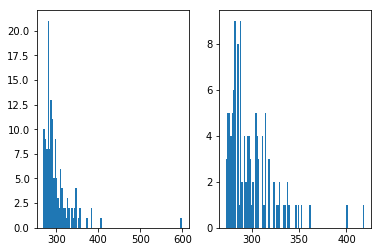

In [86]:
PETimeCor = PETime.copy()
plt.subplot(1,2,1)
plt.hist(PETime[index],bins=100)

index=(EventID==1)
time_offset = np.mean(PETime[index])

PE_tmp = PETime[index]
PE_tmp = PE_tmp[PE_tmp>time_offset - 100]
time_offset = np.mean(PE_tmp)
PETimeCor[index] = PETime[index] - time_offset

plt.subplot(1,2,2)
plt.hist(PETime[index],bins=100)
plt.show()

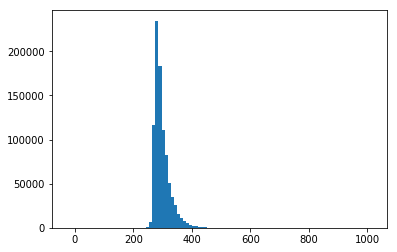

In [87]:
plt.hist(PETimeCor,bins=100)
plt.show()

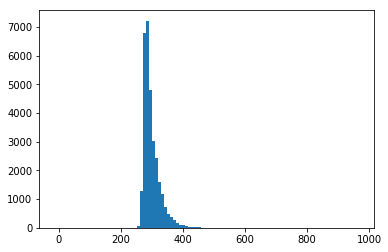

In [88]:
plt.hist(PETimeCor[ChannelID==0],bins=100)
plt.show()

In [92]:
np.std(PETimeCor[ChannelID==1])

31.19586127643295

In [91]:
a = PETimeCor[ChannelID==1]
print(type(a[0]))
a[0].astype('float64')
print(type(a[0]))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [89]:
h1 = tables.open_file(filename,'r')
print(filename)
truthtable = h1.root.GroundTruth
EventID = truthtable[:]['EventID']
ChannelID = truthtable[:]['ChannelID']
PETime = truthtable[:]['PETime']
photonTime = truthtable[:]['photonTime']
dETime = truthtable[:]['dETime']
PulseTime = truthtable[:]['PulseTime']
h1.close()

pure/calib+0.01.h5


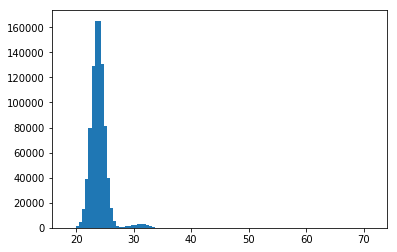

In [96]:
a = PulseTime - photonTime
a = a[a!=0]
plt.hist(a,bins=100)
plt.show()

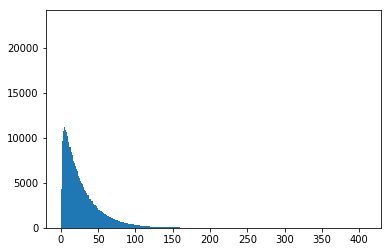

26.67157442438209


In [100]:
a = photonTime - dETime
a = a[a!=0]
plt.hist(a,bins=1000)
plt.show()
print(np.std(a))

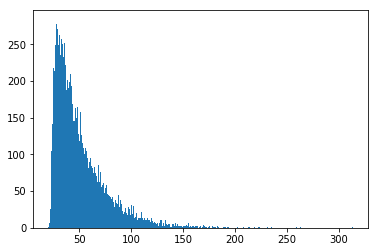

24.40021223251135


In [120]:
a = PulseTime - dETime
#a = a[a!=0]
plt.hist(a[(ChannelID==0) & (a!=0)],bins=1000)
plt.show()
print(np.quantile(a,0.03))

In [117]:
ChannelID==0 & (a!=0)

array([ True,  True, False, ..., False, False, False])

In [129]:
h1 = tables.open_file('pure/calib+0.50.h5','r')
truthtable = h1.root.GroundTruth
EventID = truthtable[:]['EventID']
ChannelID = truthtable[:]['ChannelID']
PETime = truthtable[:]['PETime']
photonTime = truthtable[:]['photonTime']
dETime = truthtable[:]['dETime']
PulseTime = truthtable[:]['PulseTime']
h1.close()
h1 = tables.open_file('pure/calib-0.50.h5','r')
truthtable = h1.root.GroundTruth
EventID1 = truthtable[:]['EventID']
ChannelID1 = truthtable[:]['ChannelID']
PETime1 = truthtable[:]['PETime']
photonTime1 = truthtable[:]['photonTime']
dETime1 = truthtable[:]['dETime']
PulseTime1 = truthtable[:]['PulseTime']
h1.close()

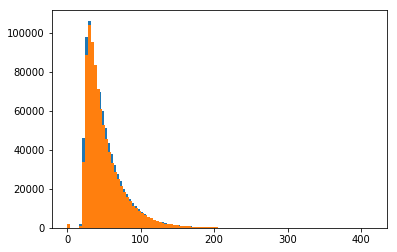

In [130]:
plt.hist(PulseTime-dETime,bins = 100)
plt.hist(PulseTime1-dETime1,bins = 100)
plt.show()